In [1]:
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import implicit
from scipy.sparse import coo_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Datasets

In [2]:
u_data = pd.read_csv('C:/Users/aishw/OneDrive/Documents/Github_Projects/RecommendationSystems/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
u_item = pd.read_csv('C:/Users/aishw/OneDrive/Documents/Github_Projects/RecommendationSystems/ml-100k/u.item', sep='|', names=['item_id', 'title'], usecols=[0, 1], encoding='latin-1')
data = pd.merge(u_data, u_item, on='item_id').drop('timestamp', axis=1)

### Exploratory Data Analysis

#### Display first few rows

In [3]:
data.head()

,user_id,item_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


#### Descriptive statistics for the ratings

In [4]:
rating_stats = data['rating'].describe()
rating_stats

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

#### Visualizing Rating Distributions

C:\Users\aishw\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


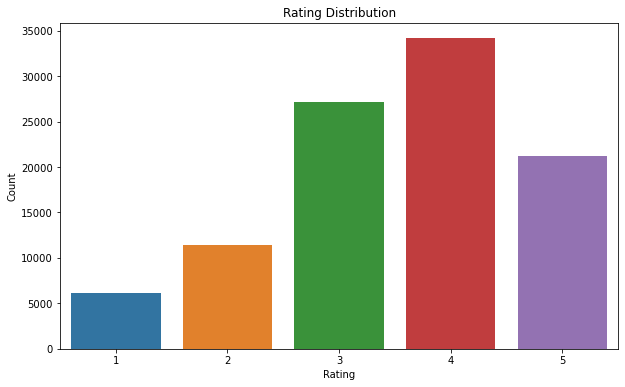

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(data['rating'])
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

#### Visualizing Popular Movies

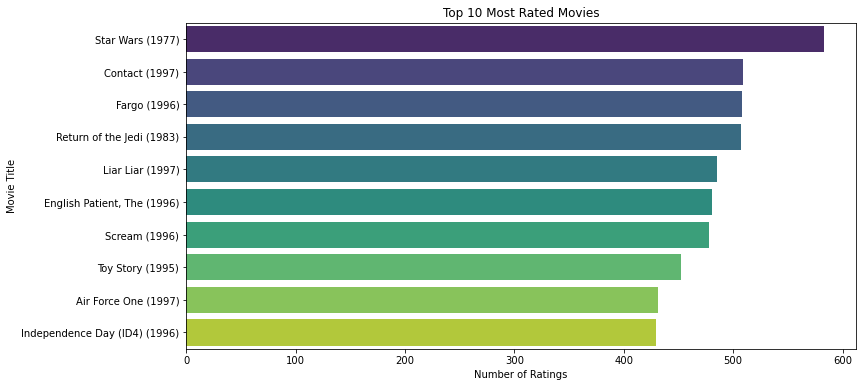

In [6]:
# Top 10 most rated movies
top_movies = data['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

#### Visualizing User Behavior

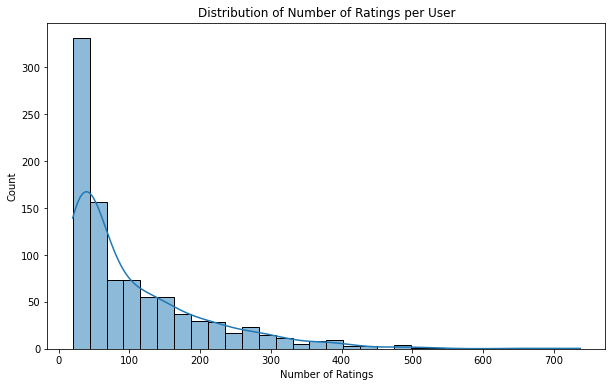

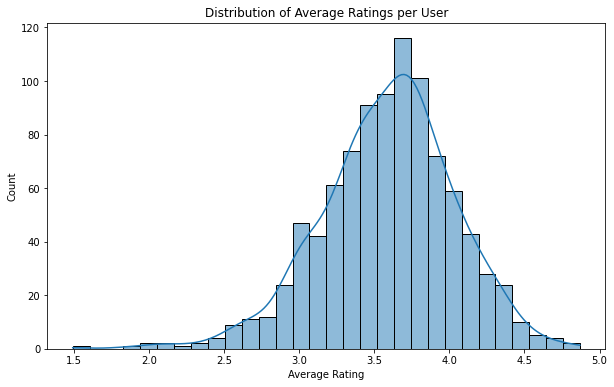

In [7]:
# Distribution of the number of ratings per user
ratings_per_user = data.groupby('user_id')['rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=30, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

# Distribution of average ratings given by users
avg_rating_per_user = data.groupby('user_id')['rating'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(avg_rating_per_user, bins=30, kde=True)
plt.title('Distribution of Average Ratings per User')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

### Data Preprocessing

#### Prepare data for Surprise

In [8]:
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

#### Split data into train and test sets

In [9]:
trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

In [10]:
# Get all unique movie IDs
all_movie_ids = data['item_id'].unique()
user_id = 1

### Recommendation System Models

#### User-Based Collaborative Filtering

In [11]:
algo_user = KNNBasic(sim_options={'user_based': True})
algo_user.fit(trainset)
predictions_user = algo_user.test(testset)
rmse_user = accuracy.rmse(predictions_user)
mae_user = accuracy.mae(predictions_user)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9858
MAE:  0.7811


In [12]:
# User-Based CF Recommendations
user_recs = [(movie_id, algo_user.predict(user_id, movie_id).est) for movie_id in all_movie_ids if not algo_user.predict(user_id, movie_id).details['was_impossible']]
top_10_user = sorted(user_recs, key=lambda x: x[1], reverse=True)[:10]

#### Item-Based Collaborative Filtering

In [13]:
algo_item = KNNBasic(sim_options={'user_based': False})
algo_item.fit(trainset)
predictions_item = algo_item.test(testset)
rmse_item = accuracy.rmse(predictions_item)
mae_item = accuracy.mae(predictions_item)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9809
MAE:  0.7772


In [14]:
# Item-Based CF Recommendations
item_recs = [(movie_id, algo_item.predict(user_id, movie_id).est) for movie_id in all_movie_ids if not algo_item.predict(user_id, movie_id).details['was_impossible']]
top_10_item = sorted(item_recs, key=lambda x: x[1], reverse=True)[:10]

#### Matrix Factorization (SVD)

In [15]:
algo_svd = SVD()
algo_svd.fit(trainset)
predictions_svd = algo_svd.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)

RMSE: 0.9408
MAE:  0.7428


In [16]:
# SVD Recommendations
rated_movie_ids = data[data['user_id'] == user_id]['item_id'].unique()
unrated_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movie_ids]
svd_predictions = [algo_svd.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
top_10_svd = sorted(svd_predictions, key=lambda x: x.est, reverse=True)[:10]
top_10_svd = [(pred.iid, pred.est) for pred in top_10_svd]

#### Content-Based Filtering

In [17]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(u_item['title'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [18]:
# Function to get recommendations based on content
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = u_item[u_item['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return u_item.iloc[movie_indices]['title']

#### Hybrid Recommendations

In [29]:
def hybrid_recommend(user_id, movie_title, top_n=10):
    content_recs = get_recommendations(movie_title)
    #print("Content-Based Recommendations (Item IDs):", content_recs)
    svd_predictions = [algo_svd.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
    svd_top_10 = sorted(svd_predictions, key=lambda x: x.est, reverse=True)[:top_n]
    cf_recs = [pred.iid for pred in svd_top_10]
    #print("Collaborative Filtering Recommendations (Item IDs):", cf_recs)
    hybrid_recs = set(content_recs).intersection(cf_recs)
    #print("Hybrid Recommendations Intersection (Item IDs):", hybrid_recs)
    if not hybrid_recs:
        hybrid_recs = cf_recs[:top_n]
    return list(hybrid_recs)

### Model Performance

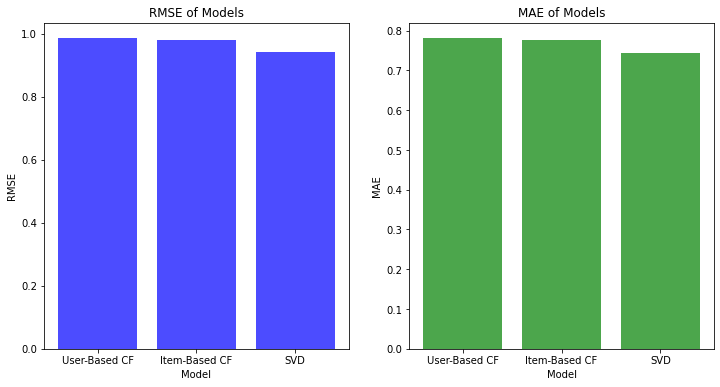

In [20]:
def plot_performance(models, rmse_values, mae_values):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(models, [v if v is not None else 0 for v in rmse_values], color='blue', alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.title('RMSE of Models')

    plt.subplot(1, 2, 2)
    plt.bar(models, [v if v is not None else 0 for v in mae_values], color='green', alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('MAE')
    plt.title('MAE of Models')
    plt.show()

models = ['User-Based CF', 'Item-Based CF', 'SVD']
rmse_values = [rmse_user, rmse_item, rmse_svd]
mae_values = [mae_user, mae_item, mae_svd]

plot_performance(models, rmse_values, mae_values)

### Top 10 Recommendations

In [21]:
# Function to print top recommendations
def print_top_10_recommendations(top_10, model_name):
    print(f"\nTop 10 {model_name} Recommendations for User {user_id}:")
    for rec in top_10:
        movie_title = u_item[u_item['item_id'] == rec[0]]['title'].values
        if len(movie_title) > 0:
            print(movie_title[0])
        else:
            print(f"Movie ID {rec[0]} not found in dataset")
            
        
# Function to visualize top recommendations
def visualize_recommendations(recommendations, model_name):
    movie_titles = []
    ratings = []
    for rec in recommendations:
        movie_id, rating = rec
        movie_title = u_item[u_item['item_id'] == movie_id]['title'].values
        if len(movie_title) > 0:
            movie_titles.append(movie_title[0])
            ratings.append(rating)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ratings, y=movie_titles, palette='magma')
    plt.title(f'Top 10 Recommendations with Ratings - {model_name}')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movie Title')
    plt.show()

#### User-Based CF Recommendations


Top 10 User-Based CF Recommendations for User 1:
Year of the Horse (1997)
Prefontaine (1997)
Santa with Muscles (1996)
Aiqing wansui (1994)
Anna (1996)
The Deadly Cure (1996)
Someone Else's America (1995)
Saint of Fort Washington, The (1993)
They Made Me a Criminal (1939)
Star Kid (1997)


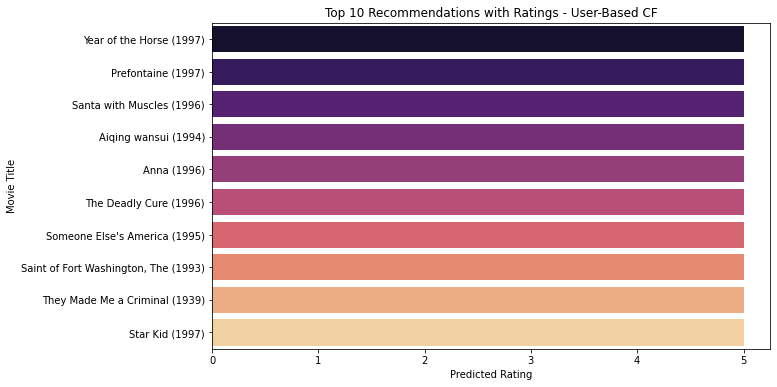

In [22]:
print_top_10_recommendations(top_10_user, 'User-Based CF')
visualize_recommendations(top_10_user, 'User-Based CF')

#### Item-Based CF Recommendations


Top 10 Item-Based CF Recommendations for User 1:
Maya Lin: A Strong Clear Vision (1994)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995)
Haunted World of Edward D. Wood Jr., The (1995)
Delicatessen (1991)
Priest (1994)
Hoop Dreams (1994)
Pillow Book, The (1995)
Nikita (La Femme Nikita) (1990)
Good, The Bad and The Ugly, The (1966)
Cyclo (1995)


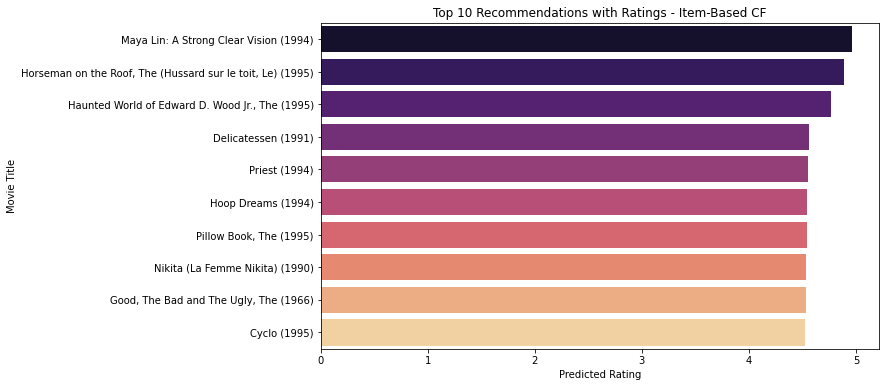

In [23]:
print_top_10_recommendations(top_10_item, 'Item-Based CF')
visualize_recommendations(top_10_item, 'Item-Based CF')

#### SVD Recommendations


Top 10 SVD Recommendations for User 1:
Maltese Falcon, The (1941)
Third Man, The (1949)
Rear Window (1954)
Secrets & Lies (1996)
Casablanca (1942)
Big Sleep, The (1946)
Lawrence of Arabia (1962)
North by Northwest (1959)
Treasure of the Sierra Madre, The (1948)
Apt Pupil (1998)


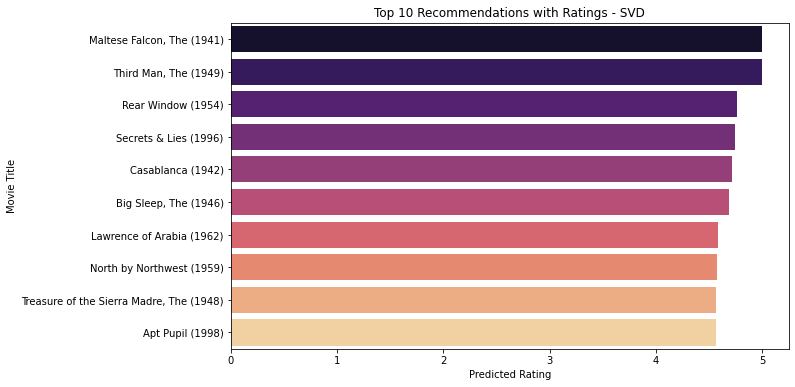

In [24]:
print_top_10_recommendations(top_10_svd, 'SVD')
visualize_recommendations(top_10_svd, 'SVD')

#### Hybrid Model Recommendations

In [30]:
hybrid_recs = hybrid_recommend(user_id, 'Toy Story (1995)')
hybrid_recs_titles = [(rec, 0) for rec in hybrid_recs]  # Assume 0 for the hybrid ratings as a placeholder
#print("Hybrid Recommendations (Item IDs):", hybrid_recs_titles)
print_top_10_recommendations(hybrid_recs_titles, 'Hybrid Model')
#visualize_recommendations(hybrid_recs_titles, 'Hybrid Model')


Top 10 Hybrid Model Recommendations for User 1:
Maltese Falcon, The (1941)
Third Man, The (1949)
Rear Window (1954)
Secrets & Lies (1996)
Casablanca (1942)
Big Sleep, The (1946)
Lawrence of Arabia (1962)
North by Northwest (1959)
Treasure of the Sierra Madre, The (1948)
Apt Pupil (1998)
